In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
import pickle
from neural_tuning import generate_tuning_curves, generate_spikes, plot_raster

%matplotlib inline
np.random.seed(1000)

In [2]:
base_dir = os.path.expanduser('~') + '/leapTracker/datafiles/direction'
train_dir = os.path.join(base_dir, 'training')
test_dir = os.path.join(base_dir, 'testing')

direction_labels = ['zero', 'fortyfive', 'ninety', 'one_thirtyfive', 
                    'one_eighty', 'two_twentyfive', 'two_seventy', 
                    'three_fifteen']
direction_labels_short = ['0', '45', '90', '135', '180', '225', '270', '315']
datafiles = dict([(direction_label, 0) for direction_label in direction_labels_short])
directions = np.linspace(0,315,8)

(50, 360)


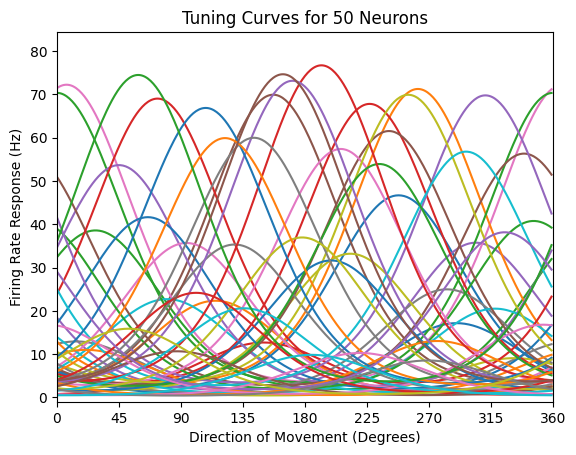

In [3]:
tuning_data = scipy.io.loadmat(os.path.join(base_dir,'tuning.mat'))
tuning_data = np.array(tuning_data['tuningMat'])

tuning_curves = generate_tuning_curves(tuning_data[1], 50)
print(tuning_curves.shape)
n_units = tuning_curves.shape[0]

for n in range(n_units):
    plt.plot(tuning_curves[n])

plt.title('Tuning Curves for {} Neurons'.format(int(n_units)))
plt.xlabel('Direction of Movement (Degrees)')
plt.ylabel('Firing Rate Response (Hz)')
plt.xlim([0, 360])
plt.ylim([-1, np.max(tuning_curves)*1.1])
plt.xticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
plt.show()

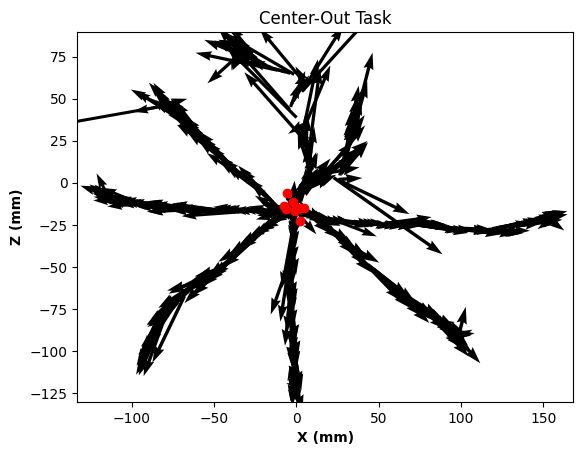

In [4]:
for n in range(len(direction_labels)):
    datafile = os.path.join(train_dir, direction_labels[n]+'_degrees.csv')
    df = pd.read_csv(datafile, index_col=False).drop(labels=0, axis=0,
                                                     inplace=False)
    
    dt = np.array(df.dt).reshape(-1,1)
    x = np.array(df.x).reshape(-1,1)
    z = np.array(df.z).reshape(-1,1)
    vx = np.array(df.vx).reshape(-1,1)
    vz = np.array(df.vz).reshape(-1,1)
    plt.plot(x[0], z[0], marker='o', color='red')
    plt.quiver(x, z, vx, vz)
    plt.xlabel('X (mm)', fontweight='bold')
    plt.ylabel('Z (mm)', fontweight='bold')
plt.title('Center-Out Task')
plt.show()

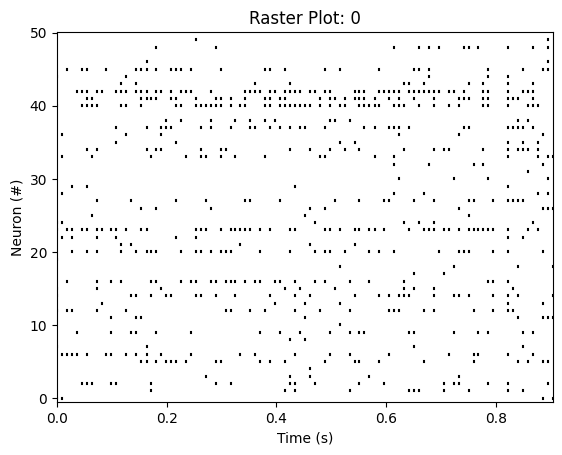

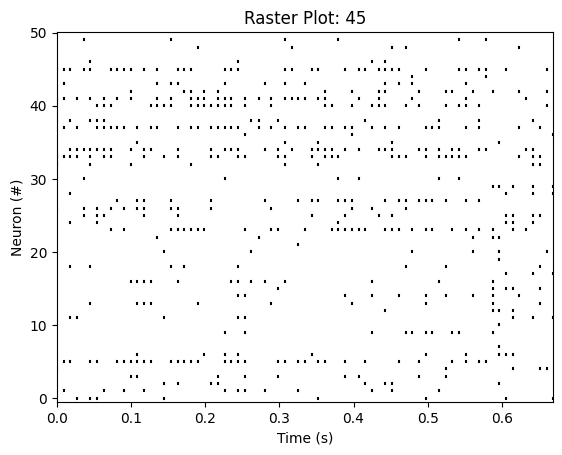

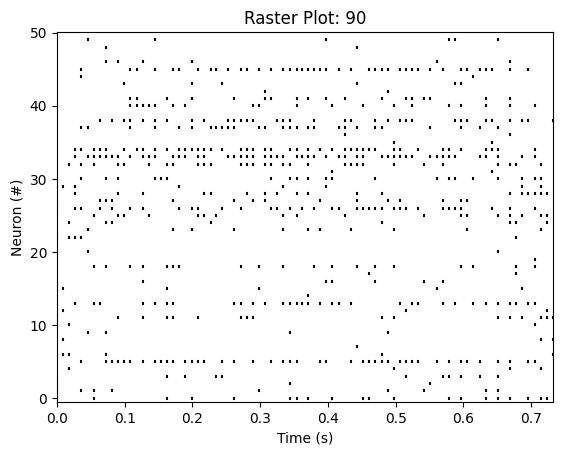

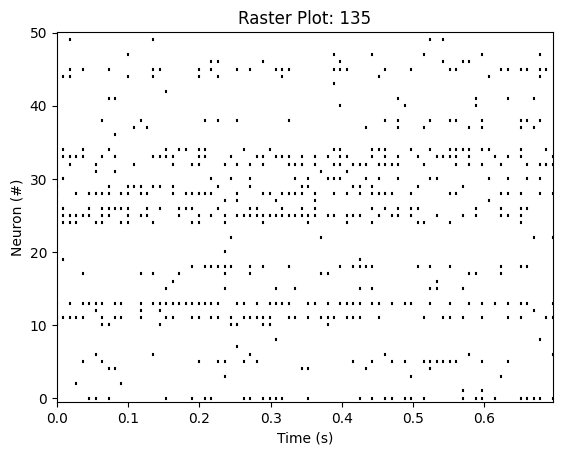

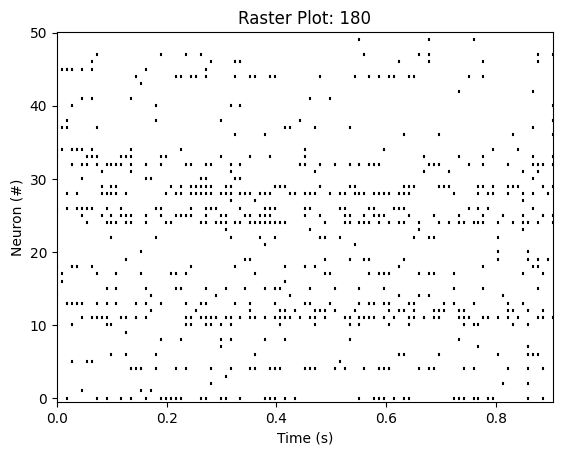

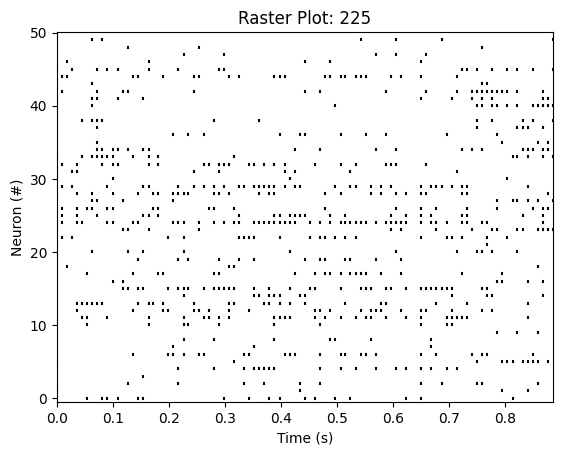

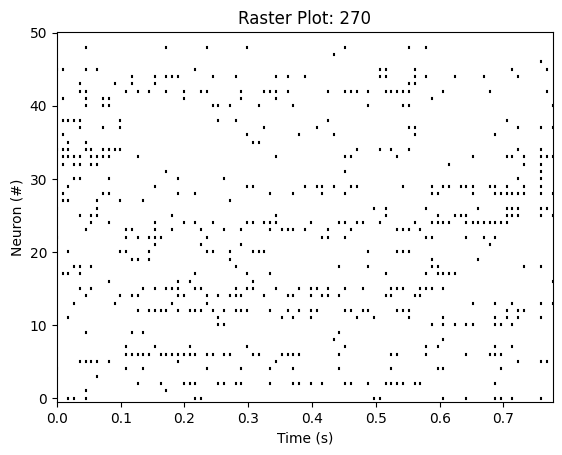

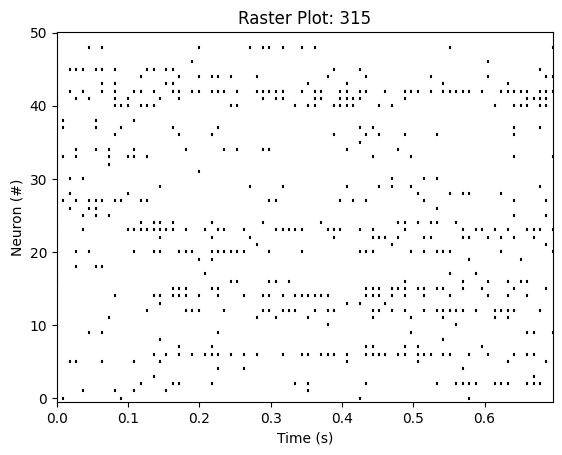

In [5]:
for n in range(len(direction_labels)):
    datafile = os.path.join(train_dir, direction_labels[n]+'_degrees.csv')
    df = pd.read_csv(datafile, index_col=False).drop(labels=0, axis=0,
                                                     inplace=False)
    dt = np.array(df.dt).reshape(-1,1)
    x = np.array(df.x).reshape(-1,1)
    z = np.array(df.z).reshape(-1,1)
    vx = np.array(df.vx).reshape(-1,1)
    vz = np.array(df.vz).reshape(-1,1)

    spikes_array = np.zeros((n_units, dt.shape[0]))
    time = np.zeros((dt.shape))

    for m in range(dt.shape[0]):
        spikes = generate_spikes(tuning_curves, dt[m], vx[m], vz[m])
        spikes_array[:,m] = spikes[:,0]
        if m > 0:
            time[m] = time[m-1] + dt[m]
 
    temp_array = np.concatenate((dt,time, x, z, vx, vz, spikes_array.T), axis=1)
    datafiles[direction_labels_short[n]] = temp_array

    plot_raster(time, spikes_array, direction_labels_short[n])

In [6]:
for label in direction_labels_short:
    data = datafiles[label]
    data = data[data[:,1]<=0.6, :]
    datafiles[label] = data
    print(datafiles[label].shape)

(67, 56)
(67, 56)
(67, 56)
(67, 56)
(67, 56)
(67, 56)
(67, 56)
(67, 56)


In [7]:
f = open(os.path.join(base_dir, 'raw_training_datafiles.pkl'), 'wb')
pickle.dump(datafiles, f)
f.close()

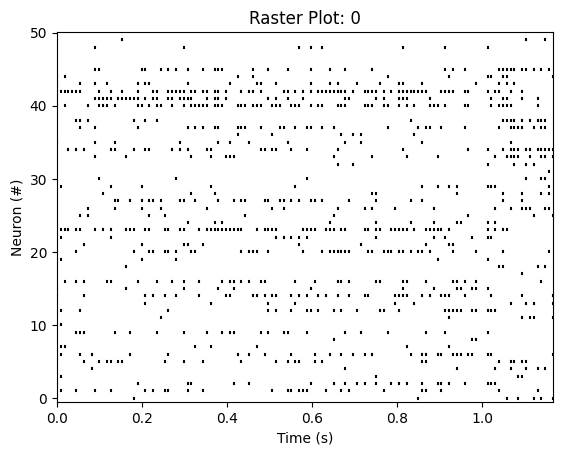

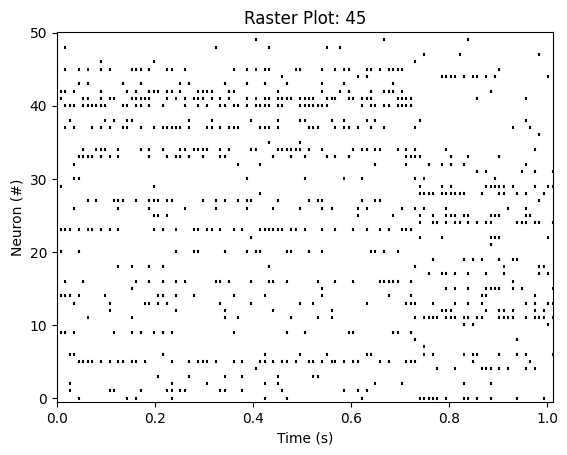

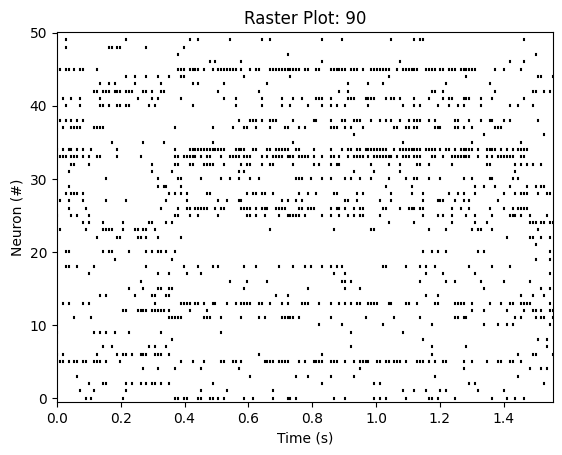

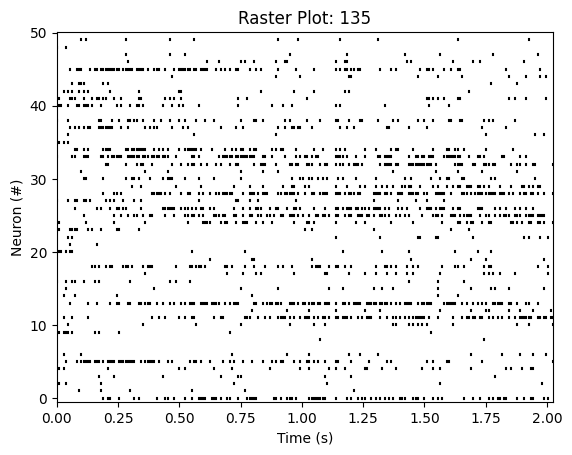

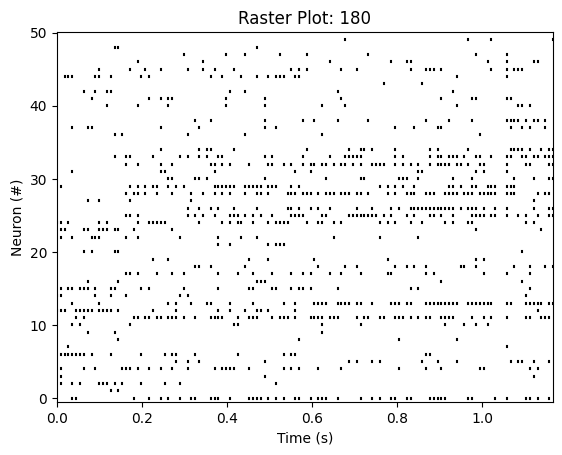

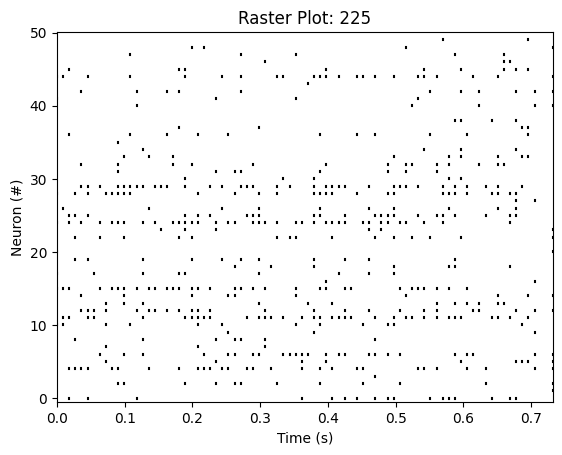

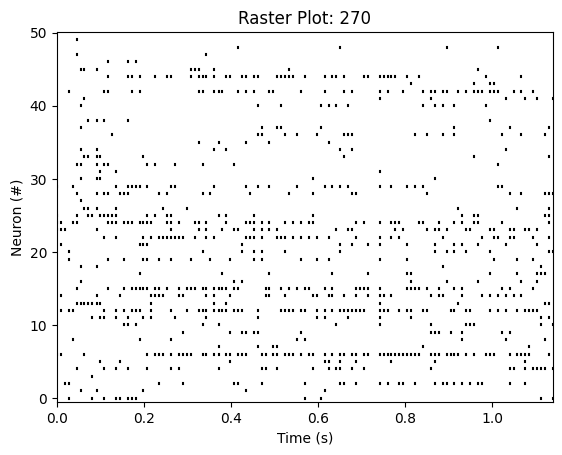

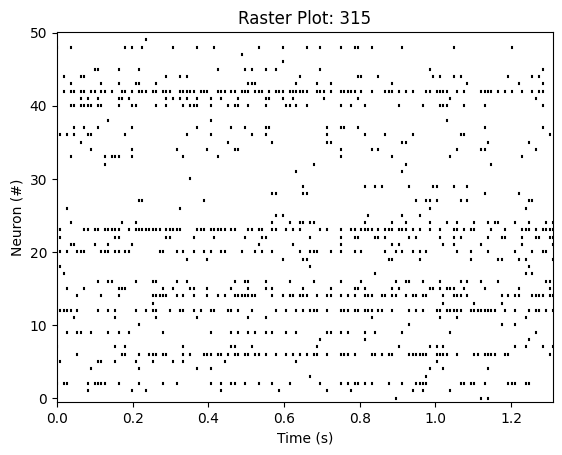

In [8]:
test_datafiles = dict()
for n in range(len(direction_labels)):
    datafile = os.path.join(test_dir,'directiontest_'+direction_labels[n]+'_degrees.csv')
    df = pd.read_csv(datafile, index_col=False).drop(labels=0, axis=0,
                                                     inplace=False)
    dt = np.array(df.dt).reshape(-1,1)
    x = np.array(df.x).reshape(-1,1)
    z = np.array(df.z).reshape(-1,1)
    vx = np.array(df.vx).reshape(-1,1)
    vz = np.array(df.vz).reshape(-1,1)

    spikes_array = np.zeros((n_units, dt.shape[0]))
    time = np.zeros((dt.shape))

    for m in range(dt.shape[0]):
        spikes = generate_spikes(tuning_curves, dt[m], vx[m], vz[m])
        spikes_array[:,m] = spikes[:,0]
        if m > 0:
            time[m] = time[m-1] + dt[m]
 
    temp_array = np.concatenate((dt,time, x, z, vx, vz, spikes_array.T), axis=1)
    test_datafiles[direction_labels_short[n]] = temp_array

    plot_raster(time, spikes_array, direction_labels_short[n])

In [9]:
for label in direction_labels_short:
    data = test_datafiles[label]
    data = data[data[:,1]<=0.6, :]
    test_datafiles[label] = data
    print(test_datafiles[label].shape)

(67, 56)
(67, 56)
(67, 56)
(67, 56)
(67, 56)
(67, 56)
(67, 56)
(67, 56)


In [10]:
f = open(os.path.join(base_dir, 'raw_test_datafiles.pkl'), 'wb')
pickle.dump(test_datafiles, f)
f.close()